In [17]:
print('Hello world!')

Hello world!


### Experimental Setting

In [18]:
REVERSE_INPUT = True
REVERSE_OUTPUT = True
OPERATOR = '+'
NUM1_RANGE = (0,999)
NUM2_RANGE = (0,999)
TRAINING_SAMPLE_SIZE = 100000
TEST_SAMPLE_SIZE = 1000
TRAINING_EPOCH = 30

### Transformer for Calculation

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import os
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset

In [20]:
random.seed(12345)
np.random.seed(12345)
torch.manual_seed(12345)
torch.cuda.manual_seed_all(12345)

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [22]:
# Dataset Class
class AdditionDataset(Dataset):
    def __init__(self, num_samples):
        self.samples = [self.generate_sample() for _ in range(num_samples)]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]
    
    @staticmethod
    def generate_sample(operator=OPERATOR, reverse_in=REVERSE_INPUT, reverse_out=REVERSE_OUTPUT):
        num1 = random.randint(NUM1_RANGE[0], NUM1_RANGE[1])
        num2 = random.randint(NUM2_RANGE[0], NUM2_RANGE[1])
        result = eval(f'{num1}{operator}{num2}')

        if reverse_in:
            num1 = str(num1)[::-1]
            num2 = str(num2)[::-1]
        else:
            num1 = str(num1)
            num2 = str(num2)

        if reverse_out:
            result = str(result)[::-1]
        else:
            result = str(result)

        return num1+operator+num2+'='+result

In [23]:
# Hyperparameter
MAX_LEN = 16
EMBED_SIZE = 384 #256
NUM_HEADS = 6 #8
NUM_LAYERS = 3 #6 #3
DROPOUT = 0 #0.1
LEARNING_RATE = 1e-6 #1e-3
EPOCHS = TRAINING_EPOCH

In [24]:
# Tokenization
ONEHOT_IDX = {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, OPERATOR: 10, '=': 11}
TOKENS = ''.join(ONEHOT_IDX.keys())
VOCAB_SIZE = len(TOKENS)

def char_to_idx(char):
    return ONEHOT_IDX[char]

def idx_to_char(idx):
    return TOKENS[idx]

In [25]:
# Model definition
class TransformerDecoderModel(nn.Module):
    def __init__(self, vocab_size, embed_size, max_len, num_heads, num_layers, dropout=0.1):
        super(TransformerDecoderModel, self).__init__()
        self.token_emb = nn.Embedding(vocab_size, embed_size)
        self.pos_enc = nn.Embedding(max_len, embed_size)

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=embed_size, 
            nhead=num_heads, 
            bias=False,
            activation='gelu',
            batch_first=True,)
        
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(embed_size, vocab_size, bias=False)
        self.dropout = nn.Dropout(dropout)
        self.pos = torch.arange(0, max_len, dtype=torch.long, device=device).unsqueeze(0) # shape (1, t)

    def forward(self, src):
        batch_size, seq_len = src.shape
        tok_emb = self.token_emb(src)  # (batch=1, seq_len, emb_dim)
        pos_emb = self.pos_enc(self.pos)[:,:seq_len,:]
        x = self.dropout(tok_emb + pos_emb)
        memory = torch.zeros_like(x)  # No encoder output
        output = self.transformer_decoder(x, memory)
        return self.fc_out(output)

In [26]:
# Visualization
def vis_pca(data, labels, title='', show=False):
    
    from sklearn.decomposition import PCA
    import matplotlib.pyplot as plt
    
    pca = PCA(n_components=8)
    transformed_list = pca.fit_transform(data.cpu().detach().numpy())  # (label cnt, pc cnt)

    plt.figure(figsize=(14, 14))

    pc_axes = [[0,1],[2,3],[4,5],[6,7]]
    for plot_id, (pcx, pcy) in enumerate(pc_axes):
        for point_id, transformed in enumerate(transformed_list):
            plt.subplot(2, 2, plot_id+1)  # plt.subplot(row, col, i)
            plt.xlabel(f'PC{pcx+1} ({pca.explained_variance_ratio_[pcx]*100:.1f}%)')
            plt.ylabel(f'PC{pcy+1} ({pca.explained_variance_ratio_[pcy]*100:.1f}%)')
            plt.scatter(transformed[pcx], transformed[pcy], alpha=0.25)
            plt.text(transformed[pcx], transformed[pcy], f"'{labels[point_id]}'")
            
    plt.suptitle(title)

    if show:
        plt.show()
    else:
        if not os.path.exists('emb_vis'): os.makedirs('emb_vis')
        plt.savefig(f'emb_vis/pca_{time.strftime("%Y%m%d-%H%M%S")}.png', bbox_inches='tight')
        plt.close()

# vis_pca(model.token_emb(torch.tensor([char_to_idx(token) for token in TOKENS]).to(device)), TOKENS, title='Test', show=True)

In [27]:
model = TransformerDecoderModel(
    vocab_size=VOCAB_SIZE,
    embed_size=EMBED_SIZE,
    max_len=MAX_LEN, 
    num_heads=NUM_HEADS, 
    num_layers=NUM_LAYERS, 
    dropout=DROPOUT,
    )
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [28]:
train_dataset = AdditionDataset(num_samples=TRAINING_SAMPLE_SIZE)
train_loader = DataLoader(train_dataset, batch_size=1)

In [29]:
model = model.to(device)

In [30]:
PCA_TITLE_PREFIX = "TOP-8 Embedding PCA"

In [31]:
data = model.token_emb(torch.tensor([char_to_idx(token) for token in TOKENS]).to(device))
vis_pca(data, TOKENS, title=f'{PCA_TITLE_PREFIX} (Epoch:0, Loss:N/A)')

In [32]:
# Train
model.train()
losses = []
for epoch in range(EPOCHS):
    epoch_loss = 0
    for batch in tqdm(train_loader):
        for data in batch:
            input_tensor = torch.tensor([char_to_idx(char) for char in data[:-1]], dtype=torch.long).unsqueeze(0).to(device)
            target_tensor = torch.tensor([char_to_idx(char) for char in data[1:]], dtype=torch.long).unsqueeze(0).to(device)

            optimizer.zero_grad()
            output = model(input_tensor)  # (batch=1, seq_len) -> (batch=1, seq_len, VOCAB_SIZE)

            output_onehot = np.argmax(output.cpu().detach(), axis=2)  # (batch=1, seq_len)
            
            pred = output.view(-1, VOCAB_SIZE)  # (seq_len, VOCAB_SIZE)
            true = target_tensor.view(-1)  # (seq_len)
            # loss = F.cross_entropy(pred, true)  # Compare all (inefficient)
            
            eqi = data[:-1].index('=')
            lhs = torch.zeros_like(pred[:eqi])
            for i in range(eqi):
                lhs[i][true[i]] = 1
            rhs_pred = torch.cat((lhs, pred[eqi:]), dim=0)  # (seq_len, VOCAB_SIZE)
            loss = F.cross_entropy(rhs_pred, true)  # Compare RHS
            
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()/len(batch)
    losses.append(epoch_loss/len(train_loader))
    print(f"Epoch {epoch+1}, Loss: {losses[-1]}")
    
    data = model.token_emb(torch.tensor([char_to_idx(token) for token in TOKENS]).to(device))
    vis_pca(data, TOKENS, title=f'{PCA_TITLE_PREFIX} (Epoch:{epoch+1}, Loss:{losses[-1]:.2f})')

plt.title('Loss'); plt.plot(losses)

100%|██████████| 100000/100000 [13:54<00:00, 119.80it/s]


Epoch 1, Loss: 1.193471152482629


100%|██████████| 100000/100000 [14:23<00:00, 115.75it/s]


Epoch 2, Loss: 1.100318825598955


100%|██████████| 100000/100000 [14:03<00:00, 118.55it/s]


Epoch 3, Loss: 1.0804359643304349


100%|██████████| 100000/100000 [13:57<00:00, 119.33it/s]


Epoch 4, Loss: 1.0745056854337454


100%|██████████| 100000/100000 [14:00<00:00, 118.98it/s]


Epoch 5, Loss: 1.0726457880997657


100%|██████████| 100000/100000 [13:37<00:00, 122.38it/s]


Epoch 6, Loss: 1.0717923177295923


100%|██████████| 100000/100000 [13:34<00:00, 122.85it/s]


Epoch 7, Loss: 1.0712456711876392


100%|██████████| 100000/100000 [13:34<00:00, 122.81it/s]


Epoch 8, Loss: 1.0709723196333647


100%|██████████| 100000/100000 [13:42<00:00, 121.57it/s]


Epoch 9, Loss: 1.0708155914545059


100%|██████████| 100000/100000 [14:16<00:00, 116.79it/s]


Epoch 10, Loss: 1.0706275155806542


100%|██████████| 100000/100000 [14:18<00:00, 116.51it/s]


Epoch 11, Loss: 1.070562745770812


100%|██████████| 100000/100000 [14:07<00:00, 117.96it/s]


Epoch 12, Loss: 1.070475559053421


100%|██████████| 100000/100000 [14:05<00:00, 118.24it/s]


Epoch 13, Loss: 1.07043724273324


100%|██████████| 100000/100000 [13:55<00:00, 119.64it/s]


Epoch 14, Loss: 1.0703566272211076


100%|██████████| 100000/100000 [14:54<00:00, 111.84it/s]


Epoch 15, Loss: 1.070354928302765


100%|██████████| 100000/100000 [15:34<00:00, 107.01it/s]


Epoch 16, Loss: 1.0703181008321048


100%|██████████| 100000/100000 [15:58<00:00, 104.33it/s]


Epoch 17, Loss: 1.070264216272235


100%|██████████| 100000/100000 [15:15<00:00, 109.26it/s]


Epoch 18, Loss: 1.0702759646606446


100%|██████████| 100000/100000 [14:53<00:00, 111.86it/s]


Epoch 19, Loss: 1.070265182005167


100%|██████████| 100000/100000 [14:25<00:00, 115.59it/s]


Epoch 20, Loss: 1.0702373054426908


100%|██████████| 100000/100000 [14:33<00:00, 114.43it/s]


Epoch 21, Loss: 1.070241919746995


100%|██████████| 100000/100000 [14:16<00:00, 116.82it/s]


Epoch 22, Loss: 1.070205408411026


100%|██████████| 100000/100000 [14:15<00:00, 116.88it/s]


Epoch 23, Loss: 1.0702043293976784


100%|██████████| 100000/100000 [13:42<00:00, 121.52it/s]


Epoch 24, Loss: 1.070190780097246


100%|██████████| 100000/100000 [13:55<00:00, 119.64it/s]


Epoch 25, Loss: 1.0701980566900968


100%|██████████| 100000/100000 [14:29<00:00, 115.04it/s]


Epoch 26, Loss: 1.0701808859747648


100%|██████████| 100000/100000 [14:42<00:00, 113.31it/s]


Epoch 27, Loss: 1.0701986294102668


100%|██████████| 100000/100000 [15:10<00:00, 109.85it/s]


Epoch 28, Loss: 1.0702004732877015


100%|██████████| 100000/100000 [14:55<00:00, 111.73it/s]


Epoch 29, Loss: 1.0701961339974404


100%|██████████| 100000/100000 [18:14<00:00, 91.34it/s]


Epoch 30, Loss: 1.0701759533089399


100%|██████████| 100000/100000 [21:27<00:00, 77.66it/s]


Epoch 31, Loss: 1.0701784729325772


100%|██████████| 100000/100000 [21:16<00:00, 78.33it/s]


Epoch 32, Loss: 1.070150798946023


100%|██████████| 100000/100000 [18:37<00:00, 89.50it/s]


Epoch 33, Loss: 1.0701718474423885


100%|██████████| 100000/100000 [20:58<00:00, 79.44it/s]


Epoch 34, Loss: 1.0701555988514424


100%|██████████| 100000/100000 [21:32<00:00, 77.39it/s]


Epoch 35, Loss: 1.0701478190553189


100%|██████████| 100000/100000 [17:36<00:00, 94.69it/s]


Epoch 36, Loss: 1.0701633023685218


 11%|█         | 10515/100000 [01:40<14:11, 105.03it/s]


KeyboardInterrupt: 

In [ ]:
test_dataset = AdditionDataset(num_samples=TEST_SAMPLE_SIZE)
test_loader = DataLoader(test_dataset, batch_size=1)

def evaluate_model(model, data):
    model.eval()  # 모델을 평가 모드로 설정
    
    pred_total = pred_correct = 0
    with torch.no_grad():
        for batch in test_loader:
            for data in batch:
                input_tensor = torch.tensor([char_to_idx(char) for char in data[:-1]], dtype=torch.long).unsqueeze(0).to(device)
                target_tensor = torch.tensor([char_to_idx(char) for char in data[1:]], dtype=torch.long).unsqueeze(0).to(device)
    
                output = model(input_tensor)

                output_onehot = np.argmax(output.cpu().detach(), axis=2)
                eqi = data[:-1].index('=')
                pred_total += len(target_tensor[0][eqi:])
                pred_correct += sum(1 for i, j in zip(target_tensor[0][eqi:], output_onehot[0][eqi:]) if i == j)
                print('sentence: ', data)
                print('target_char: ', [idx_to_char(i) for i in target_tensor[0][eqi:]])
                print('output_char: ', [idx_to_char(i) for i in output_onehot[0][eqi:]])

    return {'accuracy': pred_correct/pred_total}

accuracy = evaluate_model(model, test_dataset)['accuracy']

sentence:  465+915=3801
target_char:  ['3', '8', '0', '1']
output_char:  ['3', '8', '0', '1']
sentence:  05+934=984
target_char:  ['9', '8', '4']
output_char:  ['9', '8', '4']
sentence:  54+32=86
target_char:  ['8', '6']
output_char:  ['8', '9']
sentence:  299+455=6451
target_char:  ['6', '4', '5', '1']
output_char:  ['6', '4', '5', '1']
sentence:  44+871=222
target_char:  ['2', '2', '2']
output_char:  ['2', '2', '3']
sentence:  246+182=329
target_char:  ['3', '2', '9']
output_char:  ['3', '2', '8']
sentence:  308+114=4121
target_char:  ['4', '1', '2', '1']
output_char:  ['4', '1', '2', '1']
sentence:  167+952=0201
target_char:  ['0', '2', '0', '1']
output_char:  ['0', '2', '0', '1']
sentence:  269+762=9221
target_char:  ['9', '2', '2', '1']
output_char:  ['9', '2', '2', '1']
sentence:  319+613=9221
target_char:  ['9', '2', '2', '1']
output_char:  ['9', '2', '2', '1']


In [ ]:
print("Accuracy: ", accuracy)

Accuracy:  0.9142857142857143


In [ ]:
# Write experimental results
if not os.path.exists('emb_vis'): os.makedirs('emb_vis')
filename=f'exp_res/{accuracy*100:.0f}-InRev{REVERSE_INPUT}-OutRev{REVERSE_OUTPUT}-{NUM1_RANGE}-{NUM2_RANGE}-Train{TRAINING_SAMPLE_SIZE}-Test{TEST_SAMPLE_SIZE}-Epoch{TRAINING_EPOCH}-{time.strftime("%Y%m%d-%H%M%S")}.txt'
with open(filename, 'w') as f:
    f.write(f'Accuracy: {accuracy}\n')
    f.write(f'Loss: {losses}\n')

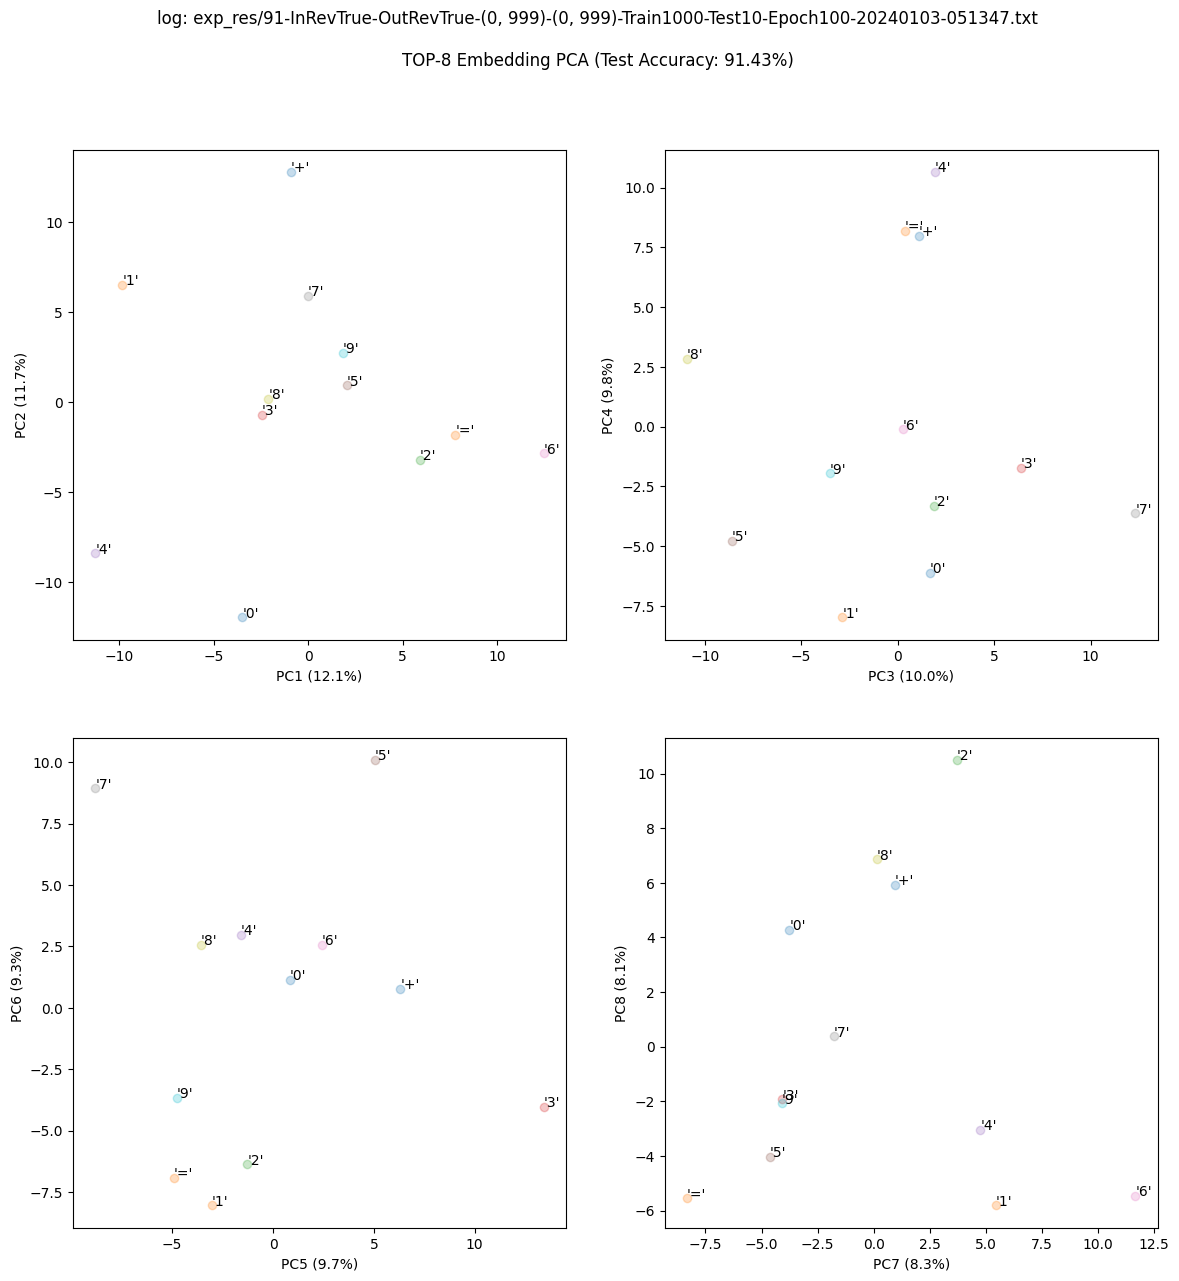

In [ ]:
vis_pca(data, TOKENS, title=f'log: {filename}\n\n{PCA_TITLE_PREFIX} (Test Accuracy: {accuracy*100:.2f}%)', show=True)